# Tracking an object using the Kalman filter





Consider an object moving in $R^2$.
We assume that we observe a noisy version of its location at each time step.
We want to track the object and possibly forecast its future motion.
We now show how to do this using a simple linear Gaussian SSM, combined with
the Kalman filter algorithm.

Let the hidden state represent
the position and velocity of the object,
$z_t =\begin{pmatrix} u_t & v_t & \dot{u}_t & \dot{v}_t \end{pmatrix}$.
(We use $u$ and $v$ for the two coordinates,
to avoid confusion with the state and observation variables.)
The process evolves in continuous time, but if we discretize it with step size $\Delta$,
we can write the dynamics as the following linear system:

\begin{align*}
\underbrace{\begin{pmatrix} u_t\\  v_t \\ \dot{u}_t \\ \dot{v}_t \end{pmatrix}}_{z_t}
  =
\underbrace{
\begin{pmatrix}
1 & 0 & \Delta & 0 \\
0 & 1 & 0 & \Delta\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
}_{F}
\underbrace{\begin{pmatrix} u_{t-1} \\  v_{t-1} \\ \dot{u}_{t-1} \\\dot{v}_{t-1} \end{pmatrix}}_{z_{t-1}}
+ q_t
\end{align*}

where $q_t \in R^4$ is the process noise, which we assume is Gaussian,
so  $q_t \sim N(0,Q)$.

Now suppose that at each discrete time point we
observe the location (but not the velocity).
We assume the observation is corrupted by  Gaussian noise.
Thus the observation model becomes

\begin{align*}
\underbrace{\begin{pmatrix}  y_{1,t} \\  y_{2,t} \end{pmatrix}}_{y_t}
  &=
    \underbrace{
    \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1& 0 & 0
    \end{pmatrix}
    }_{H}
    \;
\underbrace{\begin{pmatrix} u_t\\ v_t  \\ \dot{u}_t \\ \dot{v}_t \end{pmatrix}}_{z_t}    
 + r_t
\end{align*}

where $r_t \sim N(0,R)$ is the observation noise.
We see that the observation matrix $H$ simply ``extracts'' the
relevant parts  of the state vector.


## Setup

In [11]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [12]:
from jax import numpy as jnp
from jax import random as jr
from jax import vmap
from matplotlib import pyplot as plt

from dynamax.utils.plotting import plot_uncertainty_ellipses
from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.linear_gaussian_ssm import lgssm_smoother, lgssm_filter


## Plotting functions for data and posterior


In [18]:
# plot the posterior means and covariances from filter

def plot_lgssm_posterior(post_means, post_covs, ax=None, ellipse_kwargs={}, legend_kwargs={}, **kwargs):
    """Plot posterior means and covariances for the first two dimensions of
     the latent state of a LGSSM.  These are the states correspoding to the
     x1 and x2 positions

    Args:
        post_means: array(T, D).
        post_covs: array(T, D, D).
        ax: matplotlib axis.
        ellipse_kwargs: keyword arguments passed to matplotlib.patches.Ellipse().
        **kwargs: passed to ax.plot().
    """
    if ax is None:
        fig, ax = plt.subplots()

    # This is to stop some weird behaviour where running the function multiple
    # #  times with an empty argument wouldn't reset the dictionary.
    # if ellipse_kwargs is None:
    #     ellipse_kwargs = dict()

    # if 'edgecolor' not in ellipse_kwargs:
    #     if 'color' in kwargs:
    #         ellipse_kwargs['edgecolor'] = kwargs['color']

    # Select the first two dimensions of the latent space.
    post_means = post_means[:, :2]
    post_covs = post_covs[:, :2, :2]

    # Plot the mean trajectory
    ax.plot(post_means[:, 0], post_means[:, 1], **kwargs)
    # Plot covariance at each time point.
    plot_uncertainty_ellipses(post_means, post_covs, ax, **ellipse_kwargs)

    ax.axis("equal")

    if "label" in kwargs:
        ax.legend(**legend_kwargs)

    return ax

# plot the data and optionally plot the posterior if available


def plot_sampledata(x, y, ax = None, title = "initial trajectory"):
  observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
  if ax is None:
    fig, ax = plt.subplots()
    ax.legend(loc="upper right")
    ax.set_title(title)

  ax.plot(*x[:, :2].T, marker="s", color="C0", label="true state")
  ax.plot(*y.T, ls="-.", **observation_marker_kwargs, color="tab:green", label="emissions")


def plot_sampledata_and_posterior(x, y,  ax = None, title = None , lgssm_posterior = None):

  if ax is None:
    fig, ax = plt.subplots()
    ax.legend(loc="upper right")
    ax.set_title(title)

  plot_sampledata(x, y, ax, title)

  if lgssm_posterior is not None:
    plot_lgssm_posterior(
        lgssm_posterior.filtered_means,
        lgssm_posterior.filtered_covariances,
        ax,
        color="tab:red",
        label="filtered means",
        ellipse_kwargs={"edgecolor": "k", "linewidth": 0.5},
        legend_kwargs={"loc":"upper right"}
    )




## Create the initial model, generate a sample data trajectory from this model, and then run the filter to find the estimated states for this sample data trajectory.

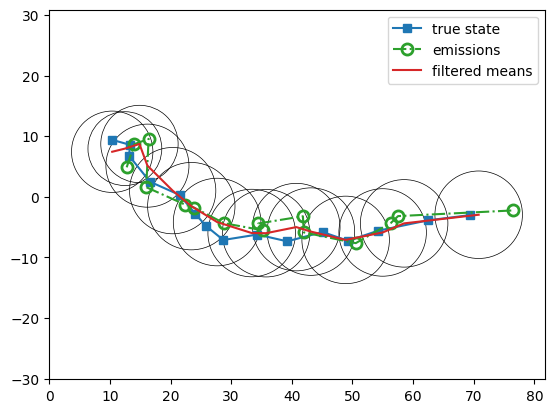

In [23]:
state_dim = 4
emission_dim = 2
delta = 1.0

# Create object
lgssm = LinearGaussianSSM(state_dim, emission_dim)

# set up the model dynamics and emission models (ratio of  emission_sigma2 to dynamics_sigma2
# is signal-to-noise ration or SNR)

dynamics_sigma2 = jnp.diag(jnp.array([1.0, 1.0, 1.0, 1.0]))
dynamics_weights  = jnp.array([[1, 0, delta, 0],
                               [0, 1, 0, delta],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])
dynamics_covariance = jnp.eye(state_dim) @ dynamics_sigma2

emission_sigma2 = jnp.diag(jnp.array([10.0, 10.0]))
emission_weights = jnp.array([[1.0, 0, 0, 0],
                              [0, 1.0, 0, 0]])
emission_covariance = jnp.eye(emission_dim) @ emission_sigma2


# now generate the initial trajectory set up the initial mean and covariance

initial_pos_sigma2 = [10.0, 10.0]
initial_vel_sigma2 = [1.0, 1.0]

initial_mean = jnp.array([8.0, 10.0, 1.0, 0.0])
initial_covariance = jnp.eye(state_dim) @  jnp.diag(jnp.array(
                              initial_pos_sigma2 + initial_vel_sigma2
                              )
                            )


# Initialize model and obtain a data sample
params, _ = lgssm.initialize(jr.PRNGKey(0),
                             initial_mean=initial_mean,
                             initial_covariance=initial_covariance,
                             dynamics_weights=dynamics_weights,
                             dynamics_covariance=dynamics_covariance,
                             emission_weights=emission_weights,
                             emission_covariance=emission_covariance)

# sample a trajectory from this model

num_timesteps = 15
key = jr.PRNGKey(310)
x, y = lgssm.sample(params, key, num_timesteps)

# run the filter and plot the sample trajectory along with the filtered means and covariance
lgssm_posterior = lgssm.filter(params, y)

# plot the data and posterior
plot_sampledata_and_posterior(x = x, y = y, lgssm_posterior=lgssm_posterior)



## Get the final mean, perturb it and generate a continuation of this trajectory but with a break in the data

In [24]:
final_mean, final_covariance = lgssm_posterior.filtered_means[-1], lgssm_posterior.filtered_covariances[-1]

# perturb the first 2 components of the final mean

print(final_mean)
innovation = jnp.array([3.0 , -3.0, 0.0, 0.0])
initial_mean = jnp.add(final_mean, innovation)
initial_covariance = final_covariance
print(initial_mean)

# Initialize model
params2, _ = lgssm.initialize(jr.PRNGKey(0),
                             initial_mean=initial_mean,
                             initial_covariance=initial_covariance,
                             dynamics_weights=dynamics_weights,
                             dynamics_covariance=dynamics_covariance,
                             emission_weights=emission_weights,
                             emission_covariance=emission_covariance)


# sample a trajectory from this new model

num_timesteps = 15
key = jr.PRNGKey(410)
x2, y2 = lgssm.sample(params2, key, num_timesteps)


[70.810974   -2.9514418   7.220169    0.79018444]
[73.810974   -5.951442    7.220169    0.79018444]


## Now that we have the new trajectory, start with the final mean and final covariance from the original trajectory as the initial mean and initial covariance for the estimation of the new trajectory, but adapt to the new data by increasing this final/initial covariance for the corresponding perturbed components of the state vector (in this case, the perturbed positions were the first 2 components of the state vector)


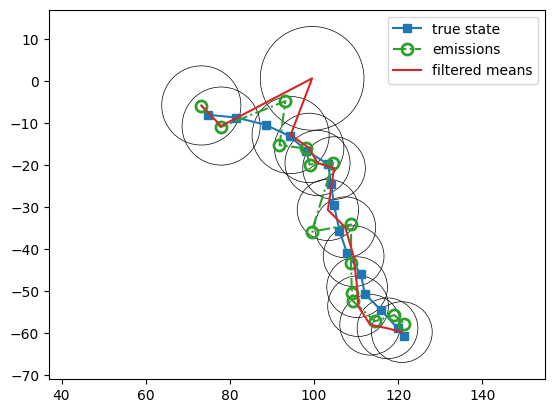

In [25]:
final_mean, final_covariance = lgssm_posterior.filtered_means[-1], lgssm_posterior.filtered_covariances[-1]

# perturb the first 2 components of the final mean


initial_mean = final_mean


initial_pos_sigma2 = [100.0, 100.0]
initial_vel_sigma2 = [1.0, 1.0]
initial_covariance = final_covariance @  jnp.diag(jnp.array(
                              initial_pos_sigma2 + initial_vel_sigma2
                              )
                            )
# Initialize model
params3, _ = lgssm.initialize(jr.PRNGKey(0),
                             initial_mean=initial_mean,
                             initial_covariance=initial_covariance,
                             dynamics_weights=dynamics_weights,
                             dynamics_covariance=dynamics_covariance,
                             emission_weights=emission_weights,
                             emission_covariance=emission_covariance)

# run the filter and plot the sample trajectory along with the filtered means and covariance
lgssm_posterior = lgssm.filter(params3, y2)

# plot the data and posterior
plot_sampledata_and_posterior(x = x2, y = y2, lgssm_posterior=lgssm_posterior)




## Perform offline smoothing

In [14]:
lgssm_posterior = lgssm.smoother(params, y)

<Axes: >

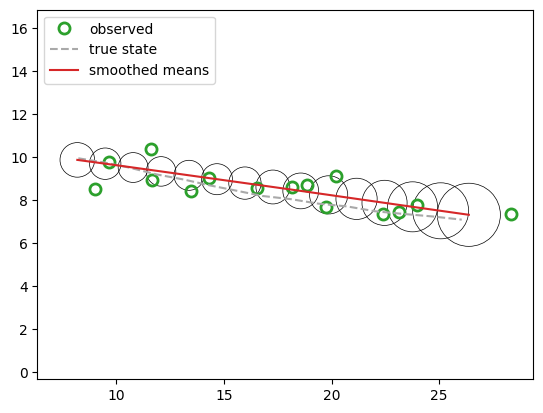

In [15]:
fig, ax = plt.subplots()
observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}

ax.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax.plot(*x[:, :2].T, ls="--", color="darkgrey", label="true state")
plot_lgssm_posterior(
    lgssm_posterior.smoothed_means,
    lgssm_posterior.smoothed_covariances,
    ax,
    color="tab:red",
    label="smoothed means",
    ellipse_kwargs={"edgecolor": "k", "linewidth": 0.5},
    legend_kwargs={"loc":"upper left"}
)

## Low-level interface to the underlying inference algorithms

We can also call the inference code directly, without having to make an LG-SSM object.
We just pass the model parameters directly to the function.

In [16]:


filtered_posterior = lgssm_filter(params, y) # Kalman filter
smoothed_posterior = lgssm_smoother(params, y) # Kalman filter + smoother
assert jnp.allclose(lgssm_posterior.filtered_means, filtered_posterior.filtered_means)
assert jnp.allclose(lgssm_posterior.filtered_means, smoothed_posterior.filtered_means)
assert jnp.allclose(lgssm_posterior.smoothed_means, smoothed_posterior.smoothed_means)

## Tracking multiple objects in parallel


In [17]:
# Generate 4 sample trajectories
num_timesteps = 15
num_samples = 4
key = jr.PRNGKey(310)
keys = jr.split(key, num_samples)
xs, ys = vmap(lambda key: lgssm.sample(params, key, num_timesteps))(keys)

In [18]:
# vmap the inference
lgssm_posteriors = vmap(lambda y: lgssm.smoother(params, y))(ys)

In [19]:
def plot_kf_parallel(xs, ys, lgssm_posteriors):
    num_samples = len(xs)
    dict_figures = {}

    # Plot Data
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*xs[n, :, :2].T, ls="--", color=f"C{n}")
        ax.plot(*ys[n, ...].T, ".", color=f"C{n}", label=f"Trajectory {n+1}")
    ax.set_title("Data")
    ax.legend()
    dict_figures["missiles_latent"] = fig

    # Plot Filtering
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*ys[n, ...].T, ".")
        filt_means = lgssm_posteriors.filtered_means[n, ...]
        filt_covs = lgssm_posteriors.filtered_covariances[n, ...]
        plot_lgssm_posterior(
            filt_means,
            filt_covs,
            ax,
            color=f"C{n}",
            ellipse_kwargs={"edgecolor": f"C{n}", "linewidth": 0.5},
            label=f"Trajectory {n+1}",
        )
    ax.legend(fontsize=10)
    ax.set_title("Filtered Posterior")
    dict_figures["missiles_filtered"] = fig

    # Plot Smoothing
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*ys[n, ...].T, ".")
        filt_means = lgssm_posteriors.smoothed_means[n, ...]
        filt_covs = lgssm_posteriors.smoothed_covariances[n, ...]
        plot_lgssm_posterior(
            filt_means,
            filt_covs,
            ax,
            color=f"C{n}",
            ellipse_kwargs={"edgecolor": f"C{n}", "linewidth": 0.5},
            label=f"Trajectory {n+1}",
        )
    ax.legend(fontsize=10)
    ax.set_title("Smoothed Posterior")
    dict_figures["missiles_smoothed"] = fig

    return dict_figures

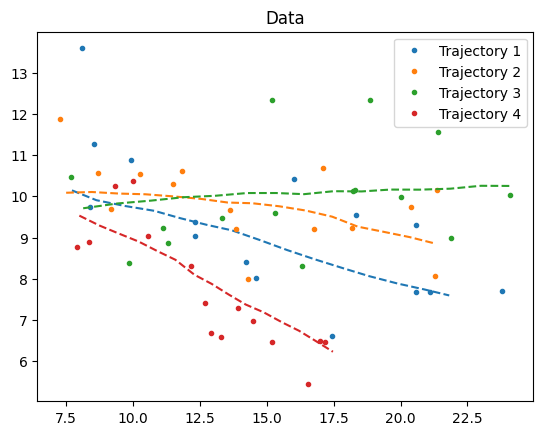

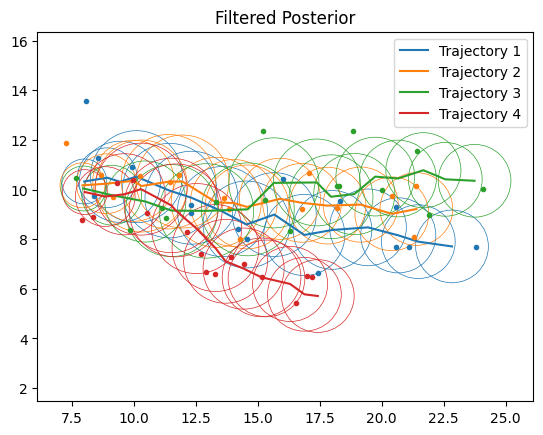

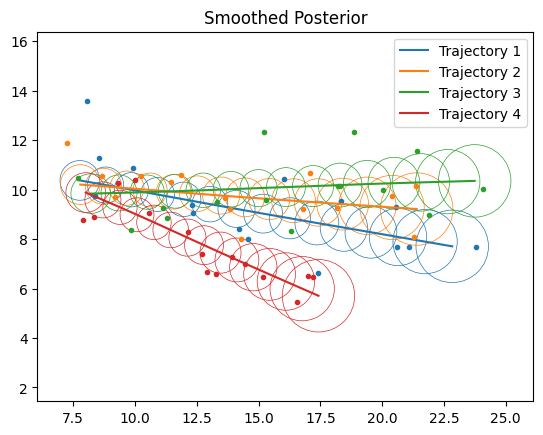

In [20]:
dict_figures = plot_kf_parallel(xs, ys, lgssm_posteriors)